# Table of contents
1. [Team members](#team)
2. [Libraries](#libraries)
3. [Exploring data](#exploring)
4. [Preprocessing data](#preprocessing)
5. [Questions](#questions)
    - [Question 1](#question-1)
    - [Question 2](#question-2)
    - [Question 3](#question-3)
    - [Question 4](#question-4)
    - [Question 5](#question-5)
6. [Modelling](#modelling)
    - [Data preparation](#modelling_preparation)
    - [Models: ](#models)
        - [Model 1 (change the number to the name of model. Ex: 1 -> Logistic Regression)](#model1)
    - [Evaluation](#evaluation)
7. [Reflection](#reflection)
    - [Difficulties during the project](#difficulties)
    - [Useful things learned](#useful)
    - [Plans to improve if have more time](#plans)
8. [References](#references)

<h1 id = "team">1. Team members</h1>
<style>
  table {
    margin: auto;
    width: 45%; /* Adjust the width as needed */
  }
  td {
    text-align: center;
    padding: 8px; /* Adding padding for better readability */
  }
  th
  {
    text-align: center;
  }
</style>

<table>
    <tr>
        <th> ID </th>
        <th> NAME </th>
    </tr>
    <tr>
        <td>22127148</td>
        <td>Dương Nhật Huy</td>
    </tr>
    <tr>
        <td>22127224</td>
        <td>Trương Thuận Kiệt</td>
    </tr>
    <tr>
        <td>22127257</td>
        <td>Phạm Minh Mẫn</td>
    </tr>
    <tr>
        <td>22127492</td>
        <td>Hồ Đăng Phúc</td>
    </tr>

<h1 id = "libraries"> 2. Libraries </h1>

In [274]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

<h1 id = "exploring"> 3. Exploring data</h1>

In [275]:
raw_data  = pd.read_csv('./Data/full_data.csv')

In [276]:
raw_data.head()

,Title,CriticScore,UserScore,Link,PlatformReleased,Cast,Director,Genre,Rating,Runtime,Studio,Release Date,Production Budget,Domestic Gross,Worldwide Gross,Formated name,Metascore,Userscore
0,L.A. Confidential,99%,94%,https://www.rottentomatoes.com/m/la_confidential,Cinema,"Kevin Spacey, Russell Crowe, Guy Pearce, James...",Curtis Hanson,"Crime, Drama",R,2h 16m,Warner Home Vídeo,"Sep 19, 1997","$35,000,000","$64,604,977","$126,204,977",l.a.confidential,91,8.6
1,The Godfather,97%,98%,https://www.rottentomatoes.com/m/the_godfather,Cinema,"Marlon Brando, Al Pacino, James Caan, Richard ...",Francis Ford Coppola,"Crime, Drama",R,2h 57m,Paramount Pictures,"Mar 15, 1972","$7,000,000","$136,479,994","$270,007,394",thegodfather,100,9.3
2,Casablanca,99%,95%,https://www.rottentomatoes.com/m/1003707-casab...,Cinema,"Humphrey Bogart, Ingrid Bergman, Paul Henreid,...",Michael Curtiz,Drama,PG,1h 42m,Warner Bros. Pictures,"Jan 23, 1943","$1,039,000","$10,462,500","$10,567,179",casablanca,100,8.7
3,Parasite,99%,90%,https://www.rottentomatoes.com/m/parasite_2019,Cinema,"Song Kang-ho, Lee Sun-kyun, Jo Yeo-jeong, Choi...",Bong Joon Ho,"Comedy, Mystery & Thriller, Drama",R,2h 12m,Neon,"May 30, 2019","$11,800,000","$53,369,745","$253,267,858",parasite,97,8.9
4,Top Gun: Maverick,96%,99%,https://www.rottentomatoes.com/m/top_gun_maverick,Cinema,"Tom Cruise, Miles Teller, Jennifer Connelly, J...",Joseph Kosinski,"Action, Adventure",PG-13,2h 11m,Paramount Pictures,"May 20, 2022","$170,000,000","$718,732,821","$1,464,400,233",topgun:maverick,78,8.4


### Number of rows and columns

In [277]:
shape = raw_data.shape  
shape

(5106, 18)

### The meaning of each line

- Each line of the dataset is a record of a movie, and all records include various features of the movie like Name, Genres, Cast, Budget, Revenue, Runtime, etc

### Duplicated rows

In [278]:
num_duplicates = raw_data.duplicated().sum()
num_duplicates

np.int64(0)

Phew, luckily no duplicated rows

### The meaning of each column

### Data type of each column

In [279]:
dtype = raw_data.dtypes
dtype

Title                object
CriticScore          object
UserScore            object
Link                 object
PlatformReleased     object
Cast                 object
Director             object
Genre                object
Rating               object
Runtime              object
Studio               object
Release Date         object
Production Budget    object
Domestic Gross       object
Worldwide Gross      object
Formated name        object
Metascore            object
Userscore            object
dtype: object

As can be seen that, all types of each colum are currently objects. Therefore, those needs re-typing

### Data retyping

In [280]:
# TODO

### Numerical column exploration

For columns with numeric data types, calculate:
- Percentage of missing values (From this and further calculation to propose a suitable approach to fill missing values of that column)
- The min
- The lower quartile
- The median
- The upper quartile
- The max
After calculating, give **visualization** to help get deeper understanding of data, from that graph/chart give some comments on the values' distribution of that column

In [281]:
# TODO

### Categorical column exploration

For columns with non-numeric data types, you calculate:
- Percentage of missing values (From this and further calculation to propose a suitable approach to fill missing values of that column)
- Count no of unique values and no of element of each value (There is a column cast is quite difficult to explore, try to find a way)
-  Give **visualization** to help get deeper understanding of data, from that graph/chart or any collected information give some comments on the values' distribution of that column

<h4>Platform Released Column<h4>

- Distribution of values

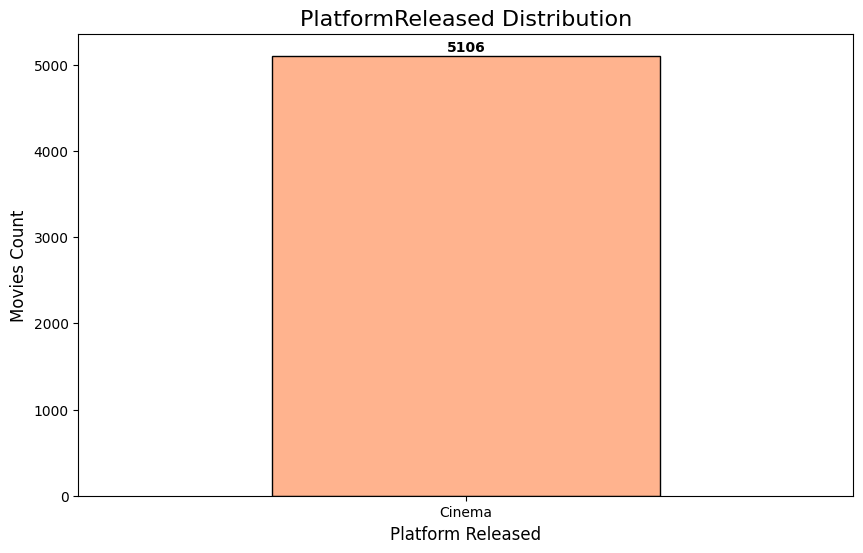

In [282]:
platform_count = raw_data['PlatformReleased'].value_counts()

plt.figure(figsize=(10, 6))
platform_count.plot(kind='bar', color='#FFB38E', edgecolor='black')

plt.title('PlatformReleased Distribution', fontsize=16)
plt.xlabel('Platform Released', fontsize=12)
plt.ylabel('Movies Count', fontsize=12)
plt.xticks(rotation=0)

for index, value in enumerate(platform_count):
    plt.text(index, value + 50, str(value), ha='center', fontsize=10, weight='bold')

plt.show()

- Percentage of missing values

In [283]:
print("Percentage of missing values in PlatformReleased: ", (raw_data['PlatformReleased'].isnull().sum() / len(raw_data)) * 100)

Percentage of missing values in PlatformReleased:  0.0


- Different values

In [284]:
print("Number of different PlatformReleased: ", len(raw_data['PlatformReleased'].unique()))
print("Different PlatformReleased: ", raw_data['PlatformReleased'].unique())

Number of different PlatformReleased:  1
Different PlatformReleased:  ['Cinema']


<h4>Cast Column<h4>

- Distribution of values

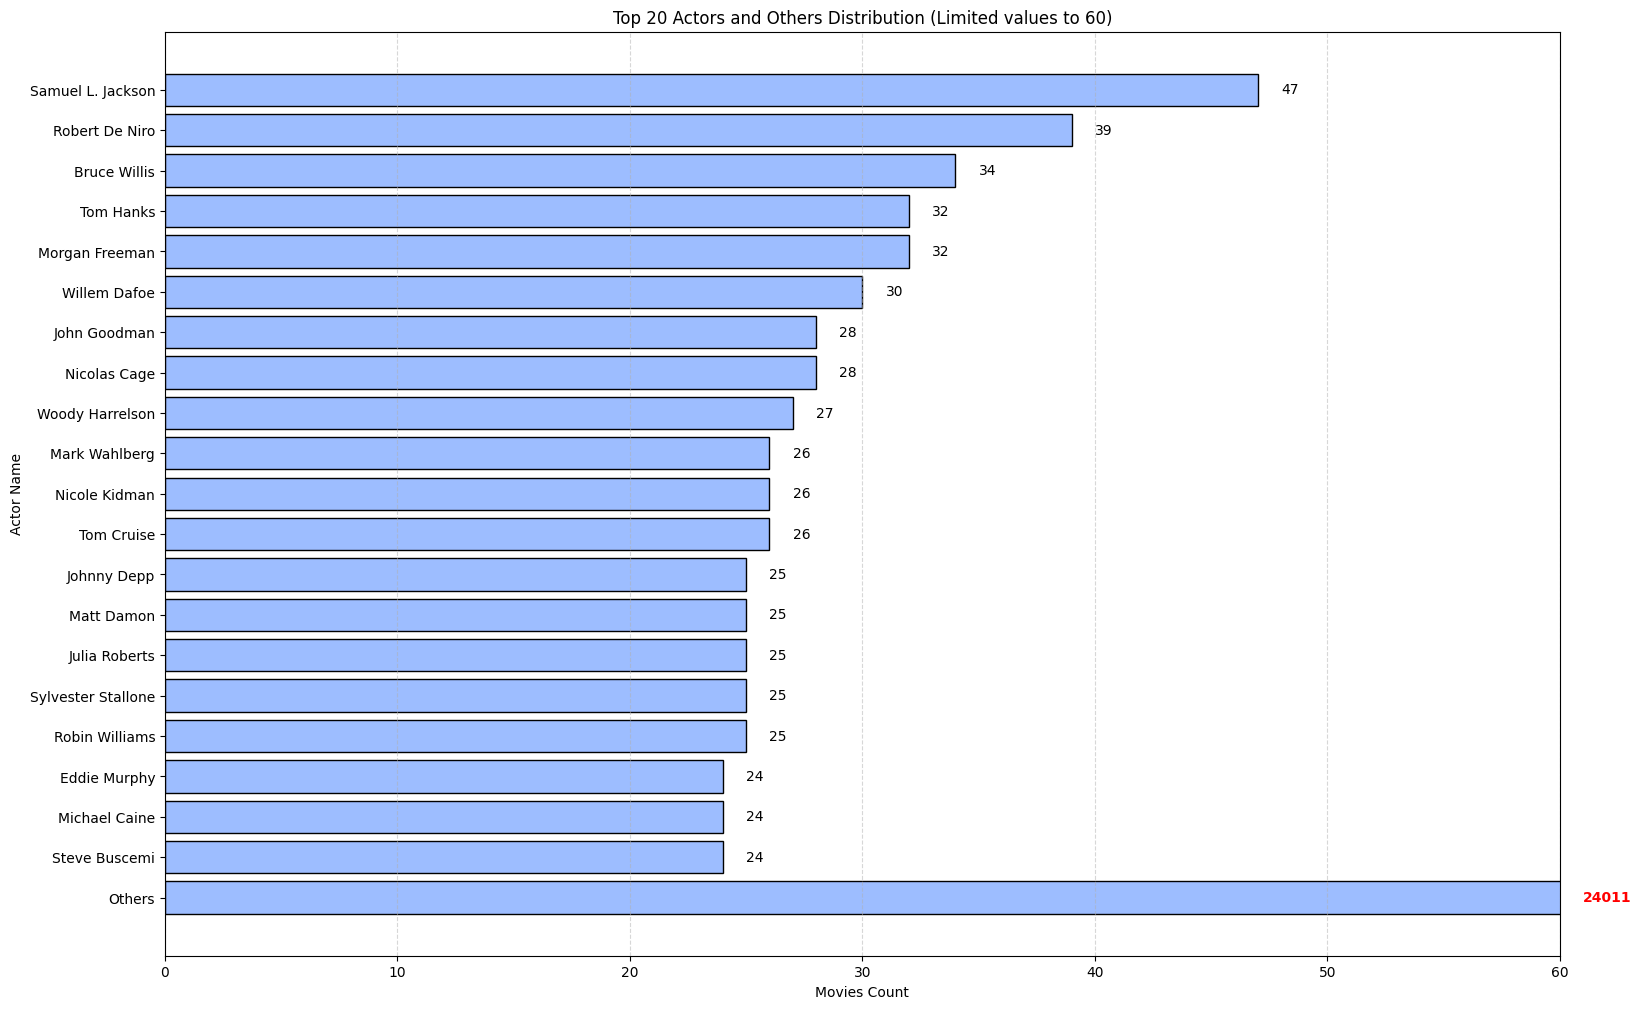

In [285]:
all_actors = raw_data['Cast'].str.split(', ').explode()

actors_count = all_actors.value_counts()

top_actors = actors_count.nlargest(20)

others_count = actors_count.iloc[20:].sum()

top_actors = pd.concat([top_actors, pd.Series({'Others': others_count})])

plt.figure(figsize=(18, 12))
bars = plt.barh(top_actors.index, top_actors.values, color='#9DBDFF', edgecolor='black')

lim = 60

for bar in bars:
    if bar.get_width() > lim:
        plt.text(lim + 1, bar.get_y() + bar.get_height()/2, 
                 f'{int(bar.get_width())}', va='center', color='red', fontsize=10, weight='bold')
    else:
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                 f'{int(bar.get_width())}', va='center', color='black', fontsize=10)
        
plt.xlim(0, lim)

plt.xlabel('Movies Count')
plt.ylabel('Actor Name')
plt.title(f'Top 20 Actors and Others Distribution (Limited values to {lim})')
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.5) 

plt.show()

- Percentage of missing values

In [286]:
print("Percentage of missing values in Cast: ", (raw_data['Cast'].isnull().sum() / len(raw_data)) * 100)

Percentage of missing values in Cast:  0.626713670191931


- Different values

In [287]:
print("Number of different Casts: ", len(actors_count))
print("Different Casts: ", actors_count.index.to_list())

Number of different Casts:  11836
Different Casts:  ['Samuel L. Jackson', 'Robert De Niro', 'Bruce Willis', 'Tom Hanks', 'Morgan Freeman', 'Willem Dafoe', 'John Goodman', 'Nicolas Cage', 'Woody Harrelson', 'Mark Wahlberg', 'Nicole Kidman', 'Tom Cruise', 'Johnny Depp', 'Matt Damon', 'Julia Roberts', 'Sylvester Stallone', 'Robin Williams', 'Eddie Murphy', 'Michael Caine', 'Steve Buscemi', 'Antonio Banderas', 'Kevin Costner', 'James Franco', 'Adam Sandler', 'Brad Pitt', 'Owen Wilson', 'Colin Farrell', 'Dwayne Johnson', 'Harrison Ford', 'Dustin Hoffman', 'Jason Statham', 'Kevin Hart', 'Ed Harris', 'Ben Kingsley', 'Ben Affleck', 'Robert Duvall', 'Robert Downey Jr.', 'Gerard Butler', 'Matthew McConaughey', 'John Cusack', 'Scarlett Johansson', 'Kristen Stewart', 'Jake Gyllenhaal', 'Susan Sarandon', 'Steve Carell', 'Ryan Reynolds', 'Denzel Washington', 'Catherine Keener', 'Julianne Moore', 'Colin Firth', 'Sandra Bullock', 'Ethan Hawke', 'Ewan McGregor', 'Christian Bale', 'Aaron Eckhart', 'Liam

<h4>Director Column<h4>

<h4>Genre Column<h4>

<h4>Rating Column<h4>

<h4>Studio Column<h4>

- Distribution of values

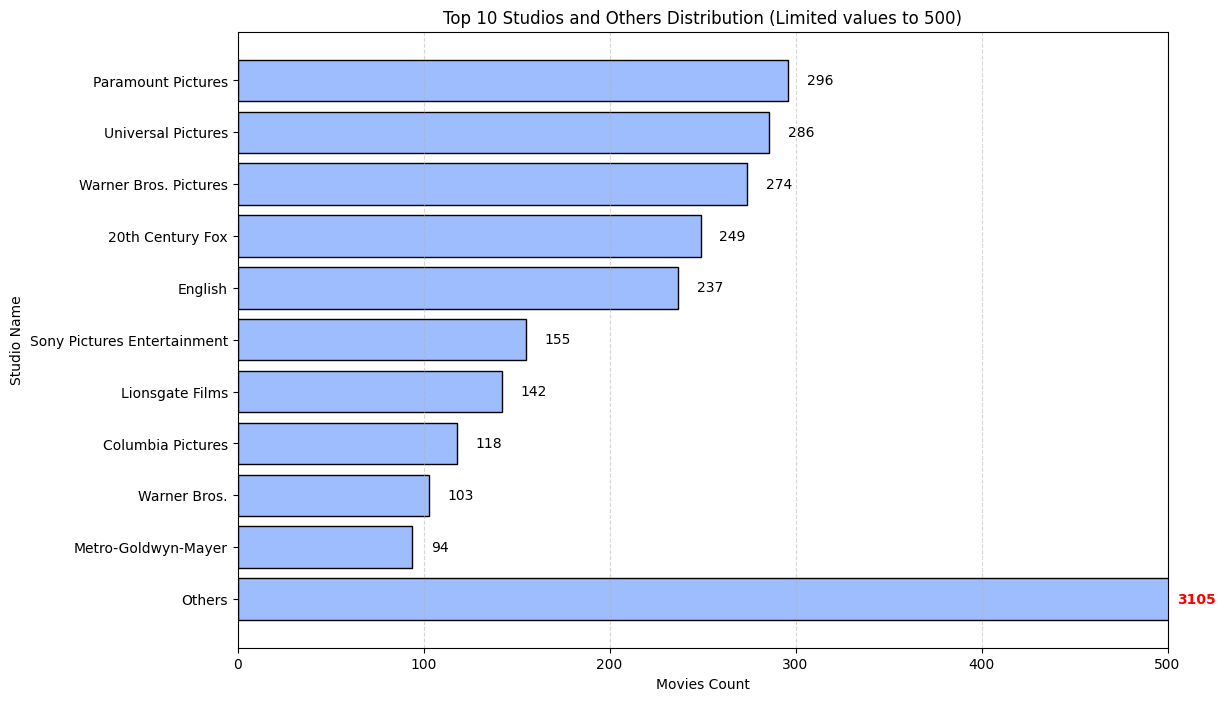

In [288]:
top_studios = raw_data['Studio'].value_counts().nlargest(10)

others_count = raw_data['Studio'].value_counts().iloc[10:].sum()

top_studios = pd.concat([top_studios, pd.Series({'Others': others_count})])

plt.figure(figsize=(12, 8))
bars = plt.barh(top_studios.index, top_studios.values, color='#9DBDFF', edgecolor='black')

lim = 500

for bar in bars:
    if bar.get_width() > lim:
        plt.text(lim + 5, bar.get_y() + bar.get_height()/2, 
                 f'{int(bar.get_width())}', va='center', color='red', fontsize=10, weight='bold')
    else:
        plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, 
                 f'{int(bar.get_width())}', va='center', color='black', fontsize=10)
        
plt.xlim(0, lim)

plt.xlabel('Movies Count')
plt.ylabel('Studio Name')
plt.title(f'Top 10 Studios and Others Distribution (Limited values to {lim})')
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.5) 

plt.show()

- Percentage of missing values

In [289]:
print("Percentage of missing values in Studio: ", (raw_data['Studio'].isnull().sum() / len(raw_data)) * 100)

Percentage of missing values in Studio:  0.9204857030943987


- Different values

In [290]:
print("Number of different Studios: ", len(raw_data['Studio'].unique()))
print("Different Studios: ", raw_data['Studio'].unique())

Number of different Studios:  1160
Different Studios:  ['Warner Home Vídeo' 'Paramount Pictures' 'Warner Bros. Pictures' ...
 'Pub CO 1' 'Pegasus Flying Films' 'Double R Productions']


<h1 id = "preprocessing"> 4. Preprocessing data </h1>

<h1 id = "questions"> 5. Questions </h1>

<h2 id = question-1>5.1. Question 1</h2> 

<h2 id = question-2>5.2. Question 2</h2> 

<h2 id = question-3>5.3. Question 3</h2> 

<h2 id = question-4>5.4. Question 4</h2> 

<h2 id = question-5>5.5. Question 5</h2> 

<h1 id = "modelling">6. Modelling</h1>

<h2 id = "modelling_preparation">6.1. Data preparation</h2> 

<h2 id = "models">6.2. Models</h2> 

<h2 id = "models">6.2. Models</h2> 

<h3 id = "model1">6.2.1 Model 1</h3> 

<h2 id = >

<h2 id = "evaluation">6.3. Evaluation</h2> 

<h1 id = "reflection">7. Reflection</h1> 

<h2 id = "difficulties">7.1. Difficulties during the project</h2> 

<h2 id = "useful">7.2. Useful things learned</h2> 

<h2 id = "plans">7.3. Plans to improve if have more time</h2> 

<h1 id = "references">8. References</h1> 